In [1]:
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
sample = 10000
bus = 57
ref_bus = 0
branch = 80

# 5 bus => 6 branch
# 9 bus => 9 branch
# 14 bus => 20 branch
# 24 bus => 38 branch
# 39 bus => 46 branch
# 57 bus => 80 branch
# 118 bus => 186 branch

# Load data from csv into variables
with open('data_x_pf_%d.csv' %bus) as xcvs:
    readCSV = csv.reader(xcvs, delimiter=',')
    data_x = np.ones([bus*3,sample])
    i = 0
    for row in readCSV:
        data_x[i,:] = row
        i = i+1
        
with open('data_y_pf_%d.csv' %bus) as ycvs:
    readCSV = csv.reader(ycvs, delimiter=',')
    data_y = np.ones([branch*2,sample])
    i = 0
    for row in readCSV:
        data_y[i,:] = row
        i = i+1        
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

In [3]:
# Separate generate data into  training, val, test data set
lenx , sample = data_x.shape
leny , sample = data_y.shape
num1 = int(0.8*sample)
num2 = int(0.1*sample)

train_x = torch.Tensor(data_x[:,0:num1]).transpose(0, 1)
val_x   = torch.Tensor(data_x[:,num1:(num1+num2)]).transpose(0, 1)
test_x  = torch.Tensor(data_x[:,(num1+num2):sample]).transpose(0, 1)

train_y = torch.Tensor(data_y[:,0:num1]).transpose(0, 1)
val_y   = torch.Tensor(data_y[:,num1:(num1+num2)]).transpose(0, 1)
test_y  = torch.Tensor(data_y[:,(num1+num2):sample]).transpose(0, 1)


In [4]:
# Reshape the data set into correct size
train_x = train_x.reshape(num1,int(lenx/bus),bus).to(device)   
train_x = train_x.transpose(1,2)
val_x   = val_x.reshape(num2,int(lenx/bus),bus).to(device)   
val_x   = val_x.transpose(1,2)
test_x  = test_x.reshape(num2,int(lenx/bus),bus).to(device)   
test_x  = test_x.transpose(1,2)


train_y = train_y.reshape(num1,int(leny/branch),branch).to(device)   
train_y = torch.abs(train_y.transpose(1,2))
val_y   = val_y.reshape(num2,int(leny/branch),branch).to(device)   
val_y   = torch.abs(val_y.transpose(1,2))
test_y  = test_y.reshape(num2,int(leny/branch),branch).to(device)   
test_y  = torch.abs(test_y.transpose(1,2))

In [5]:
# Normalize the data into range between -1 and 1

def normalize(data):
    x , y , z = data.shape
    max_val = torch.reshape(torch.amax(torch.abs(data),1),(x,1,z))
    norm = torch.divide(data,max_val).transpose(1,2)
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm, max_val

def normalize_y(data):
    x , y , z = data.shape
    avg_val = torch.mean(data)
    std_val = torch.std(data)
    norm = torch.divide(data-avg_val,std_val).transpose(1,2)
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm, avg_val, std_val

In [6]:
# Training model

class PowerFlow(nn.Module):
    def __init__(self):
        super(PowerFlow,self).__init__()
        #layer definitions
        self.FC1   = nn.Linear(bus*3,500)
        self.FC2   = nn.Linear(500,100)
        self.FC3   = nn.Linear(100,50)
        self.FC4   = nn.Linear(50,branch*2)
        self.act   = nn.LeakyReLU(0.3)

    def forward(self, x):
        x = self.act(self.FC1(x))
        x = self.act(self.FC2(x))
        x = self.act(self.FC3(x))
        x = self.FC4(x)
        return x
    
# Loss function
def MSE(ypred,ytrue):
    loss = nn.MSELoss()
#     loss = nn.L1Loss()
    return loss(ypred,ytrue)

def abs_error(ypred,ytrue,ref):
    error = torch.abs(ypred - ytrue) #/ torch.abs(ytrue)
#     error[ytrue == 0] = torch.abs(ypred[ytrue == 0])
    mean_error = torch.mean(error)*100
    return mean_error.detach().cpu().numpy()
    



In [7]:
# Define training variables

CNNPF = PowerFlow().to(device)
optimizer = optim.SGD(CNNPF.parameters(), lr=0.0001, momentum=0.7)
# optimizer = optim.Adam(CNNPF.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-07, weight_decay=0.1, amsgrad=False)
hloss = []
train_err = []
val_err = []
n = 0
num_epochs  = 8000
batch = 250
iter = int(num1/batch)
disp = 4

norm_train_x, max_train_x = normalize(train_x)
norm_train_y, avg_train_y, std_train_y = normalize_y(train_y)
norm_val_x,   max_val_x   = normalize(val_x)
norm_val_y,   avg_val_y,   std_val_y   = normalize_y(val_y)

# Start training
CNNPF = CNNPF.train()

for epoch in range(num_epochs):
    index = np.random.choice(num1, batch*iter, replace=False)
    index = np.reshape(index,[iter,batch])
    
    for i in range(iter):
        CNNPF = CNNPF.train()
        X = norm_train_x[index[i,:],:]     
        Y = norm_train_y[index[i,:],:]
        
        optimizer.zero_grad()

        # Forward + backward + optimize
        Y_pred = CNNPF(X)
        loss = MSE(Y_pred,Y)
        loss.backward()
        optimizer.step()
        n += 1
        
    if epoch % disp == 0:
    
        hloss.append(loss.detach().cpu().numpy()) 
        CNNPF = CNNPF.eval()
        pred_y = CNNPF(norm_val_x).detach()
        error = abs_error(pred_y,norm_val_y,ref_bus)
        val_err.append(error) 

        pred_y = CNNPF(norm_train_x).detach()
        error = abs_error(pred_y,norm_train_y,ref_bus)
        train_err.append(error)        

        print(loss.detach().cpu().numpy()) 


0.083419785
0.082588606
0.08343967
0.08194511
0.08148217
0.07990598
0.08169406
0.08157416
0.08173203
0.08122115
0.08044817
0.080067836
0.079950035
0.08027674
0.07914864
0.07916338
0.07979368
0.078701444
0.07844362
0.078505695
0.07898347
0.07874116
0.07866661
0.07834133
0.07689411
0.078239135
0.07701773
0.07648515
0.07708701
0.076137155
0.076901294
0.07707127
0.07803295
0.076930076
0.07613899
0.076510385
0.07515776
0.075300105
0.0761579
0.0754465
0.07613987
0.07648099
0.07566056
0.07489249
0.07531666
0.074403405
0.075956725
0.07591584
0.07385478
0.073715076
0.07482658
0.074200794
0.07288955
0.07400836
0.07191978
0.07284658
0.0730025
0.07501845
0.07373917
0.073079936
0.07242422
0.07298269
0.07246902
0.07221113
0.07222002
0.07108596
0.07211778
0.07149689
0.0714979
0.071184985
0.07071909
0.07177271
0.07077777
0.06989191
0.07050875
0.07016298
0.06976298
0.07040423
0.07077608
0.06886062
0.069004975
0.06736891
0.06912418
0.06947971
0.068797156
0.0696563
0.068429835
0.06978971
0.067475334
0.06

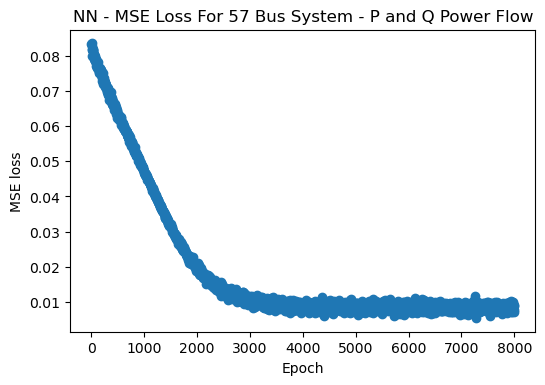

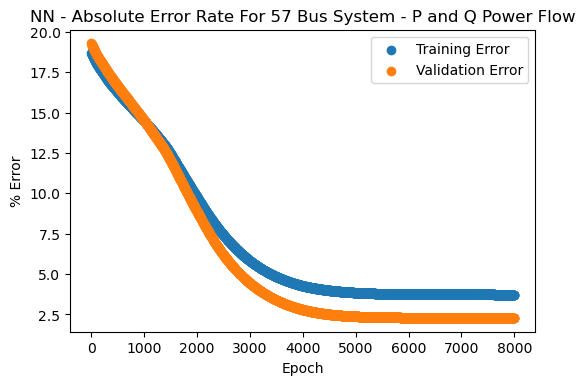

In [8]:
# Plot the result  
plt.figure(dpi=100)       
plt.scatter(range(0,num_epochs,disp),hloss)
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('NN - MSE Loss For {} Bus System - P and Q Power Flow'.format(bus))
plt.savefig("Graph_NN/NN_Loss_PQ_{}.png".format(bus))

plt.figure(dpi=100) 
plt.scatter(range(0,num_epochs,disp),train_err, label = "Training Error")
plt.scatter(range(0,num_epochs,disp),val_err, label = 'Validation Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Error")
plt.title('NN - Absolute Error Rate For {} Bus System - P and Q Power Flow'.format(bus))
plt.savefig("Graph_NN/NN_Error_PQ_{}.png".format(bus))

In [53]:
Y = Y.reshape(num2,branch,2)
Y_pred = Y_pred.reshape(num2,branch,2)
print(Y[11,:].detach().cpu().numpy())
print(Y_pred[11,:].detach().cpu().numpy())

a = Y[10,1:10].detach().cpu().numpy()
b = Y_pred[10,1:10].detach().cpu().numpy()

# c = np.abs(a-b)
# d = np.mean(c)
# print(norm_train_y[7,25].detach().cpu().numpy())
# print(c)
# print(d)
# print(norm_train_y[8,:].detach().cpu().numpy())
# print(max_train_y[8])
# print(norm_train_y.shape)

RuntimeError: shape '[1000, 80, 2]' is invalid for input of size 40000

In [54]:
# Start eval
CNNPF = CNNPF.eval()

norm_test_x,   max_test_x   = normalize(test_x)
norm_test_y,   max_test_y   = normalize(test_y)
pred_y = CNNPF(norm_test_x)
error = abs_error(pred_y,norm_test_y,ref_bus)
print(error)

2.338247


In [11]:
a = torch.rand(5,5)
b = torch.ones(5,5)
c = torch.ones(5,5)*3
b[2,2] = 0
b[3,4] = 0
print(a,b)
print(b == 0)
a[b == 0] = c[b == 0]
print(torch.mean(b))


tensor([[0.0246, 0.6759, 0.2469, 0.6544, 0.2572],
        [0.7385, 0.1423, 0.6139, 0.4680, 0.8393],
        [0.1488, 0.2740, 0.5541, 0.5993, 0.1106],
        [0.9103, 0.3396, 0.8250, 0.8272, 0.0860],
        [0.2247, 0.7958, 0.9342, 0.7857, 0.7289]]) tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
tensor([[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False]])
tensor(0.9200)


In [12]:
t = torch.tensor([[1,2],[3,4]])
torch.gather(t, 1,torch.tensor([[0,0],[0,0]]))

tensor([[1, 1],
        [3, 3]])

In [13]:
t = torch.rand(4,5)
torch.mean(t,0)
print(torch.mean(t,0))
print(t)

tensor([0.6498, 0.6557, 0.3692, 0.5090, 0.6506])
tensor([[0.2847, 0.6218, 0.9067, 0.8202, 0.2678],
        [0.8747, 0.8759, 0.4101, 0.2376, 0.6557],
        [0.8928, 0.7142, 0.0488, 0.2867, 0.9593],
        [0.5470, 0.4111, 0.1111, 0.6914, 0.7196]])


In [47]:
Y = pred_y.reshape(num2,branch,2)


print(Y.shape)
print(max_test_y.shape)

result = Y * max_test_y
result = result.reshape(num2,branch*2)
result = result.transpose(0,1).detach().cpu().numpy()
print(result.shape)

test = test_y.reshape(num2,branch*2)
test = test.transpose(0,1).detach().cpu().numpy()
print(test.shape)



torch.Size([1000, 80, 2])
torch.Size([1000, 1, 2])
(160, 1000)
(160, 1000)


In [61]:
# result = Y * max_test_y
Y = norm_test_y.reshape(num2,branch,2)
Y_pred = pred_y.reshape(num2,branch,2)
print(Y[7,1:10].detach().cpu().numpy())
print(Y_pred[7,1:10].detach().cpu().numpy())



[[0.23496155 0.16517073]
 [0.02447837 0.07001619]
 [0.11318342 0.2629371 ]
 [0.03567089 0.13469042]
 [0.14844924 0.00369132]
 [0.27263102 0.29933712]
 [0.14401156 0.06119614]
 [0.06272948 0.32090455]
 [0.01908835 0.02443575]]
[[0.30557373 0.17462505]
 [0.08433865 0.1502848 ]
 [0.10366742 0.30157736]
 [0.05662848 0.14802814]
 [0.1360107  0.04686502]
 [0.24172577 0.29511112]
 [0.2220827  0.09770209]
 [0.09691794 0.28704068]
 [0.02646974 0.02537511]]


In [48]:


with open('y_predict.csv', 'w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(10):
        csv_writer.writerow(result[i,:])
        csv_writer.writerow(test[i,:])
        

In [70]:
print(torch.mean(test_y,0).shape)

print(torch.std(test_y))


torch.Size([80, 2])
tensor(10.5018, device='cuda:0')


In [ ]:
torch(train_x)